# Single TSC - multivariate time series
# (["ds1", "ds2", "ds3", "mf1", "mf2", "mf3"])

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa import stattools
import torch

In [2]:
data = pd.read_csv("../../Preprocessing/v2/preprocessed_data_v2.csv")

# Convert "recorded" column to Python datetime objects
data["recorded"] = pd.to_datetime(data["recorded"], format="%Y-%m-%d %H:%M:%S")
data.head(len(data))

,recorded,ct,ss,tsc,ds1,mf1,rf1,ds2,mf2,rf2,ds3,mf3,rf3
0,2021-02-20 20:00:00,110.0,2446,87,42.0,12.0,12.00,47.00,14.00,14.0,25.00,8.00,7.00
1,2021-02-20 20:00:00,110.0,2480,221,36.0,9.0,10.00,60.00,17.00,18.0,16.00,4.00,5.00
2,2021-02-20 20:00:00,110.0,2475,203,38.0,12.0,11.00,38.00,12.00,11.0,19.00,6.00,5.00
3,2021-02-20 20:00:00,110.0,2473,188,41.0,16.0,17.00,39.00,15.00,15.0,24.00,8.00,9.00
4,2021-02-20 20:00:00,110.0,2469,181,41.0,12.0,12.00,37.00,10.00,11.0,23.00,7.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271515,2021-06-18 16:15:00,140.5,2447,278,63.5,36.0,34.75,35.75,24.25,23.5,22.25,15.25,13.75
271516,2021-06-18 16:15:00,140.5,2447,88,93.5,33.5,35.00,69.50,25.00,25.5,48.50,19.00,19.50
271517,2021-06-18 16:15:00,140.5,2446,87,78.0,33.0,33.00,87.00,38.00,38.0,68.00,31.00,30.00
271518,2021-06-18 16:15:00,140.5,2480,221,81.5,24.5,26.00,83.00,28.00,28.5,89.50,31.50,31.50


### Why LSTM > RNN?
    1) Corrects for vanishing and exploding gradients
    2) Simpler training
    3) Better for processing very long sequences

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### ACF and PACF plots to determine optimal lag length (i.e. train window) for LSTM model for each TSC

In [4]:
# Relevant TSCs linked to Coronation drive
tscs = [87, 88, 278, 181, 188, 203, 221, 364]

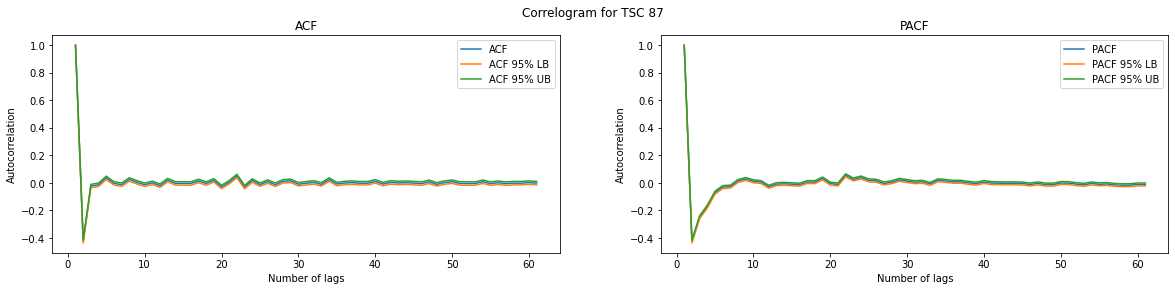

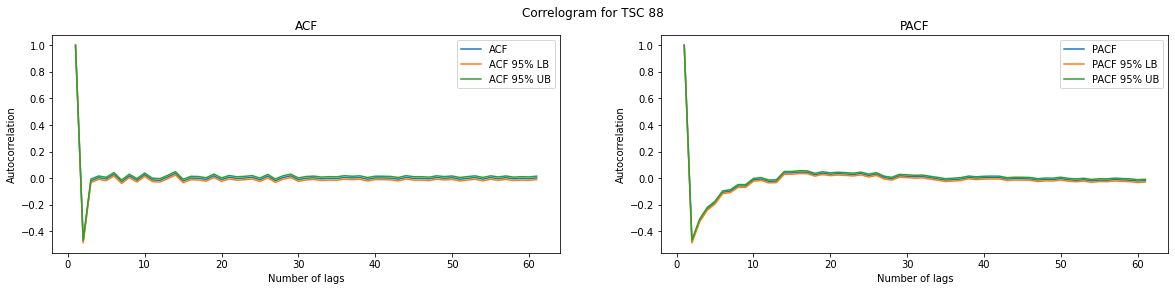

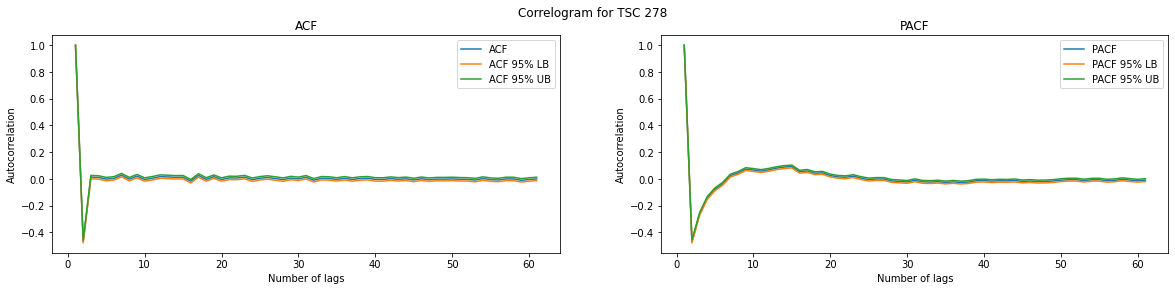

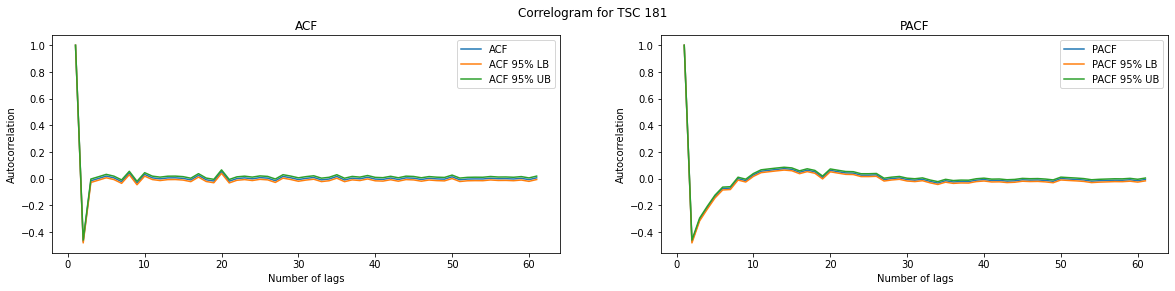

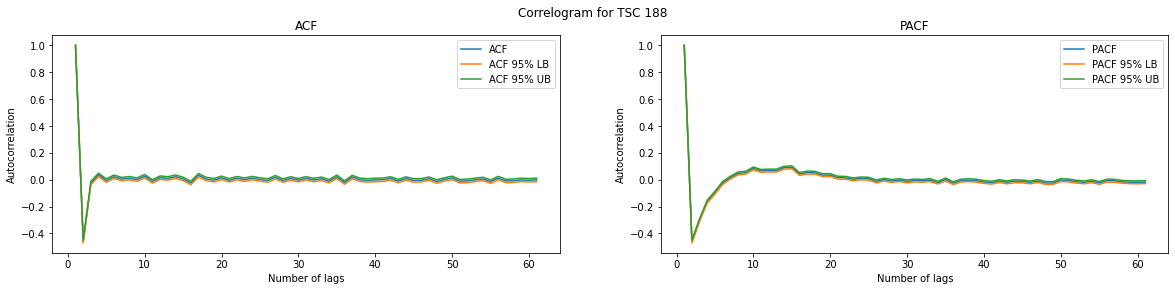

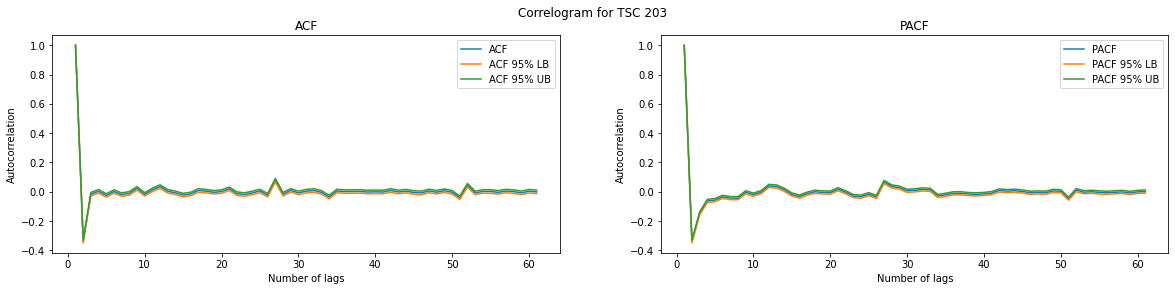

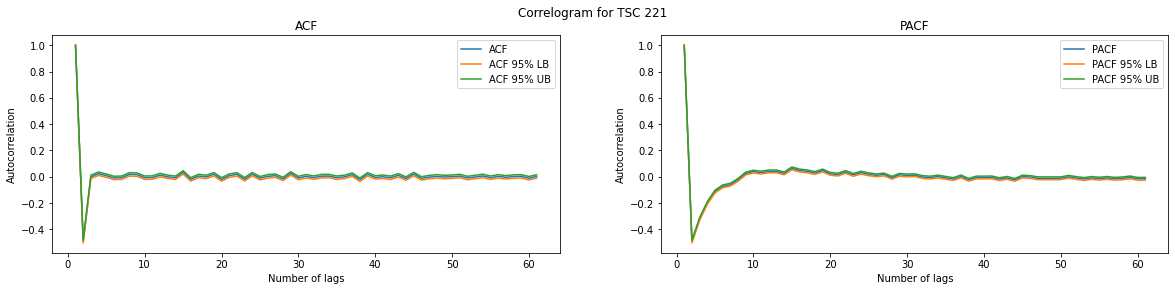

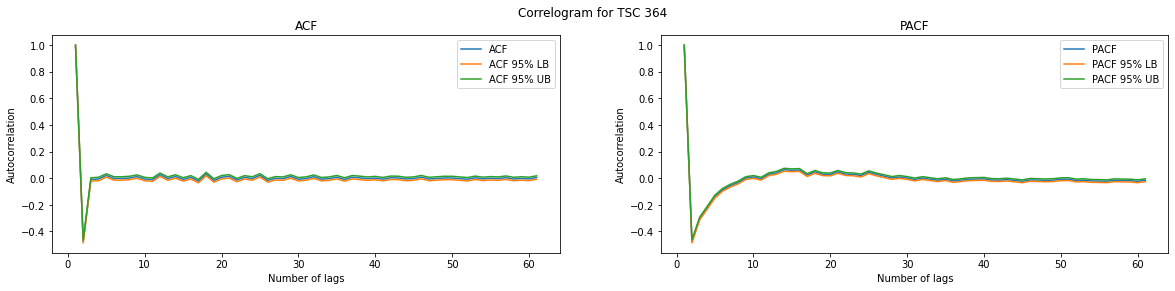

In [5]:
tsc_windows = dict()
for tsc in tscs:
    # Only based on "ds" columns for now
    dataset = data[data["tsc"] == tsc][["ds1", "ds2", "ds3"]].mean(axis=1).values.astype("float32").reshape(-1, 1)
    
    # Correct for 0 values before applying log and first difference filters (log(0) = -inf)
    temp_dataset = np.copy(dataset)
    for i in range(len(dataset)):
        if temp_dataset[i] == 0:
            temp_dataset[i] += 0.0001
    
    # Apply log filter then first difference filter (corrects for non-stationarity in the mean and variance)
    temp_dataset = np.diff(np.log(temp_dataset), axis=0)
    
    # With 5 min intervals, nlags=60 corresponds to 5*60 = 300 mins or 300/60 = 5 hours sliding windows
    acf, confint_acf = stattools.acf(temp_dataset, nlags=60, fft=True, alpha=0.05)
    pacf, confint_pacf = stattools.pacf(temp_dataset, nlags=60, alpha=0.05)
    
    # Plot Correlograms for each TSC
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20, 4))
    axes[0].plot(range(1, len(acf) + 1), acf, label="ACF")
    axes[0].plot(range(1, len(acf) + 1), confint_acf[:, 0], label="ACF 95% LB")
    axes[0].plot(range(1, len(acf) + 1), confint_acf[:, 1], label="ACF 95% UB")
    axes[0].set_xlabel("Number of lags")
    axes[0].set_ylabel("Autocorrelation")
    axes[0].set_title("ACF")
    axes[0].legend()

    axes[1].plot(range(1, len(pacf) + 1), pacf, label="PACF")
    axes[1].plot(range(1, len(pacf) + 1), confint_pacf[:, 0], label="PACF 95% LB")
    axes[1].plot(range(1, len(pacf) + 1), confint_pacf[:, 1], label="PACF 95% UB")
    axes[1].set_xlabel("Number of lags")
    axes[1].set_ylabel("Autocorrelation")
    axes[1].set_title("PACF")
    axes[1].legend()

    fig.suptitle(f"Correlogram for TSC {tsc}")
    
    # Find optimal lag based on hypothesis testing, sqrt(T)*phi_hat ~ N(0, 1)
    # H0: No i-th order partial autocorrelation (phi = 0)
    # H1: There is i-th order partial autocorrelation (phi =/= 0)
    optimal_lag = -1
    for lag in range(len(pacf)):
        if np.sqrt(len(temp_dataset)) * abs(pacf[lag]) > 1.96:
            optimal_lag = lag
    
    tsc_windows[tsc] = optimal_lag

In [6]:
tsc_windows

{87: 60, 88: 60, 278: 59, 181: 59, 188: 60, 203: 50, 221: 60, 364: 60}

### Preprocessing for LSTM model
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python

In [7]:
max_samples = 1000

# Scale features to [0, 1] to help in training
num_features = 6
dataset = data[data["tsc"] == tsc][["ds1", "ds2", "ds3", "mf1", "mf2", "mf3"]].values.astype("float32").reshape(-1, num_features)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Train with only max_samples number of samples
dataset = dataset[:max_samples]

print(dataset[:5])
print(dataset.shape)

[[0.18120806 0.22297297 0.06711409 0.1923077  0.25531915 0.11627907]
 [0.17785235 0.2027027  0.0704698  0.21153846 0.25531915 0.11627907]
 [0.2080537  0.23198198 0.10961969 0.21153846 0.28368792 0.17829457]
 [0.25055927 0.21396397 0.09395973 0.30128208 0.29078013 0.1627907 ]
 [0.15212527 0.22072074 0.05816555 0.17307693 0.26950353 0.09302326]]
(1000, 6)


In [8]:
# Training set = 90%, testing set = 10%
train_size = int(len(dataset)*(9/10))
test_size = len(dataset) - train_size

train_data, test_data = dataset[:train_size, :], dataset[train_size:, :]
train_data = torch.cuda.FloatTensor(train_data).view(-1, num_features)
test_data = torch.cuda.FloatTensor(test_data).view(-1, num_features)

In [9]:
# Transforms training data into required time series sequence and label form for training
def to_sequences(train_data, train_window=1):
    sequences = []

    for i in range(len(train_data) - train_window - 1):
        # print(i)
        # ADD SECOND INDEX FOR MULTIVARIATE TIME SERIES
        sequence = train_data[i:i + train_window, :].view(-1, num_features)
        label = train_data[i + train_window, :].view(-1, num_features)
        sequences.append((sequence, label))
        
    return sequences

In [10]:
# Train window = optimal lag length for given TSC
train_window = tsc_windows[tsc]
train_seq = to_sequences(train_data, train_window)

print(train_seq[:2])

[(tensor([[0.1812, 0.2230, 0.0671, 0.1923, 0.2553, 0.1163],
        [0.1779, 0.2027, 0.0705, 0.2115, 0.2553, 0.1163],
        [0.2081, 0.2320, 0.1096, 0.2115, 0.2837, 0.1783],
        [0.2506, 0.2140, 0.0940, 0.3013, 0.2908, 0.1628],
        [0.1521, 0.2207, 0.0582, 0.1731, 0.2695, 0.0930],
        [0.2114, 0.2466, 0.0906, 0.2212, 0.2872, 0.1395],
        [0.2148, 0.2635, 0.0694, 0.2244, 0.3262, 0.1163],
        [0.1991, 0.2252, 0.0604, 0.2179, 0.2766, 0.1008],
        [0.1007, 0.1847, 0.0492, 0.1218, 0.2270, 0.0775],
        [0.1980, 0.2534, 0.0604, 0.2115, 0.3191, 0.1047],
        [0.1678, 0.2568, 0.0738, 0.1923, 0.3121, 0.1240],
        [0.1834, 0.2005, 0.0626, 0.1987, 0.2482, 0.1085],
        [0.1879, 0.2534, 0.0671, 0.2212, 0.3298, 0.1163],
        [0.2081, 0.2680, 0.0872, 0.2308, 0.3121, 0.1395],
        [0.1767, 0.2703, 0.0694, 0.2051, 0.3333, 0.1163],
        [0.1544, 0.2331, 0.0872, 0.1827, 0.2979, 0.1395],
        [0.2349, 0.2635, 0.0738, 0.2628, 0.3262, 0.1163],
        [0.1

### PyTorch LSTM implementation

In [11]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size=num_features, hidden_layer_size=200, hidden_layers=2, output_size=num_features, dropout=0):
        """
        Inputs:
            input_size - corresponds to the number of features in the input.
            hidden_layer_size - specifies the number of hidden layers along with the number of neurons in each layer.
            output_size - the number of items in the output.
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.hidden_layers = hidden_layers

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, hidden_layers, dropout=dropout)

        self.fc1 = torch.nn.Linear(hidden_layer_size, hidden_layer_size)
        
        # Adding an additional dense layer here
        self.fc2 = torch.nn.Linear(hidden_layer_size, output_size)

        # Hidden and cell states initialisation
        self.hidden_cell = (torch.zeros(hidden_layers, 1, self.hidden_layer_size).to(device),
                            torch.zeros(hidden_layers, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        """
        Same as model(input_seq).item()
        """
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        fc1_out = self.fc1(lstm_out)
        predictions = self.fc2(fc1_out.view(len(input_seq), -1))
        return predictions[-1]

### Loss function and optimiser

In [12]:
model = LSTM().cuda()
# MSE as loss function
loss_fn = torch.nn.MSELoss()
# Adam optimiser for optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(model)

LSTM(
  (lstm): LSTM(6, 200, num_layers=2)
  (fc1): Linear(in_features=200, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=6, bias=True)
)


### Training the LSTM model

In [13]:
# Training iterations
num_epochs = 10
# To plot training loss curve after completion of training
loss = []

for i in range(1, num_epochs + 1):
    for seq, label in train_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(model.hidden_layers, 1, model.hidden_layer_size).to(device),
                             torch.zeros(model.hidden_layers, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq).reshape(-1, 6)

        single_loss = loss_fn(y_pred, label)
        single_loss.backward()
        optimizer.step()

    # if i % 10 == 1:
    print(f'Epoch {i} loss: {single_loss.item():10.8f}')
    
    loss.append(single_loss.item())

Epoch 1 loss: 0.01088058
Epoch 2 loss: 0.00842986
Epoch 3 loss: 0.00486232
Epoch 4 loss: 0.00334688
Epoch 5 loss: 0.00242481
Epoch 6 loss: 0.00133160
Epoch 7 loss: 0.00072197
Epoch 8 loss: 0.00123523
Epoch 9 loss: 0.00157839
Epoch 10 loss: 0.00005137


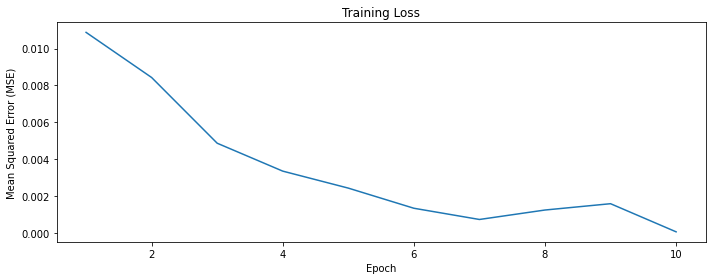

In [14]:
# Plot loss curve
plt.figure(figsize=(10, 4))
plt.plot(range(1, i + 1), loss)
# plt.plot(range(1, i), loss)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training Loss")
plt.tight_layout()

### Predictions using trained model

In [15]:
pred_window = 12
pred_df = data[data["tsc"] == tsc][["recorded", "ds1", "ds2", "ds3", "mf1", "mf2", "mf3"]][train_size - train_window:max_samples]
pred_df[["scaled_ds1", "scaled_ds2", "scaled_ds3", "scaled_mf1", "scaled_mf2", "scaled_mf3"]] = train_data.tolist()[-train_window:] + test_data.tolist()
pred_df.head(len(pred_df))

,recorded,ds1,ds2,ds3,mf1,mf2,mf3,scaled_ds1,scaled_ds2,scaled_ds3,scaled_mf1,scaled_mf2,scaled_mf3
6721,2021-02-23 18:00:00,93.5,123.5,89.0,8.5,9.5,10.0,0.627517,0.834459,0.597315,0.163462,0.202128,0.232558
6730,2021-02-23 18:05:00,83.0,116.0,94.5,7.5,11.0,9.0,0.557047,0.783784,0.634228,0.144231,0.234043,0.209302
6737,2021-02-23 18:10:00,87.5,111.0,87.0,17.0,20.5,22.5,0.587248,0.750000,0.583893,0.326923,0.436170,0.523256
6745,2021-02-23 18:15:00,86.5,93.5,81.5,30.0,34.5,35.5,0.580537,0.631757,0.546980,0.576923,0.734043,0.825581
6755,2021-02-23 18:20:00,42.0,49.0,26.5,22.5,26.5,16.5,0.281879,0.331081,0.177852,0.432692,0.563830,0.383721
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7964,2021-02-24 06:55:00,65.5,65.5,47.0,31.5,32.0,26.0,0.439597,0.442568,0.315436,0.605769,0.680851,0.604651
7973,2021-02-24 07:00:00,71.0,69.0,43.0,33.5,35.0,26.0,0.476510,0.466216,0.288591,0.644231,0.744681,0.604651
7979,2021-02-24 07:05:00,66.5,79.5,50.5,30.5,39.5,28.0,0.446309,0.537162,0.338926,0.586538,0.840425,0.651163
7990,2021-02-24 07:10:00,87.5,69.0,59.5,36.0,31.5,29.0,0.587248,0.466216,0.399329,0.692308,0.670213,0.674419


### Predict 12 time steps (5*12 ~ 60 minutes) into the future and keep updating these future predictions  (via averaging) with each timestep into the future. In other words, each timestep in test_data has 12 predictions averaged out to form a single prediction

In [16]:
pred_dict = dict()
model.eval()

for i in range(len(pred_df) - train_window - pred_window):
    test_inputs = pred_df[["scaled_ds1", "scaled_ds2", "scaled_ds3", "scaled_mf1", "scaled_mf2", "scaled_mf3"]].values[i:i + train_window]
    seq = torch.cuda.FloatTensor(test_inputs)
    
    for j in range(pred_window):
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                            torch.zeros(1, 1, model.hidden_layer_size).to(device))
            pred = model(seq).cpu().tolist()
            if pred_dict.get(pred_df["recorded"].iloc[i + train_window + j]) is None:
                n = 1
                pred_dict[pred_df["recorded"].iloc[i + train_window + j]] = np.array([n] + pred)
            else:
                n = pred_dict[pred_df["recorded"].iloc[i + train_window + j]][0]
                mean = pred_dict[pred_df["recorded"].iloc[i + train_window + j]][1:]

                # Inremental averaging
                pred_dict[pred_df["recorded"].iloc[i + train_window + j]][1:] = (n*mean + np.array(pred))/(n + 1)
                pred_dict[pred_df["recorded"].iloc[i + train_window + j]][0] += 1
                
        test_inputs = np.append(test_inputs, np.array(pred).reshape(1, num_features), axis=0)
        seq = torch.cuda.FloatTensor(test_inputs[-train_window:, :])
        
# pred_dict

In [17]:
pred_df = pred_df.iloc[train_window:]

# Merge predictions results with pred_df dataframe
temp_df = pd.DataFrame(pred_dict.values(), index=pred_dict.keys(), columns=["n", "scaled_pred_ds1", "scaled_pred_ds2", "scaled_pred_ds3", "scaled_pred_mf1", "scaled_pred_mf2", "scaled_pred_mf3"])
temp_df.insert(0, column="recorded", value=temp_df.index)
temp_df.reset_index(drop=True, inplace=True)
temp_df["n"] = temp_df["n"].apply(int)

pred_df = pred_df.merge(temp_df, on="recorded")

In [18]:
# Need to reverse transform from [0, 1] back to original "ds1", "ds2", "ds3"
pred_df[["pred_ds1", "pred_ds2", "pred_ds3", "pred_mf1", "pred_mf2", "pred_mf3"]] = scaler.inverse_transform(pred_df[["scaled_pred_ds1", "scaled_pred_ds2", "scaled_pred_ds3", "scaled_pred_mf1", "scaled_pred_mf2", "scaled_pred_mf3"]].values)

# pred_df.head(len(pred_df))

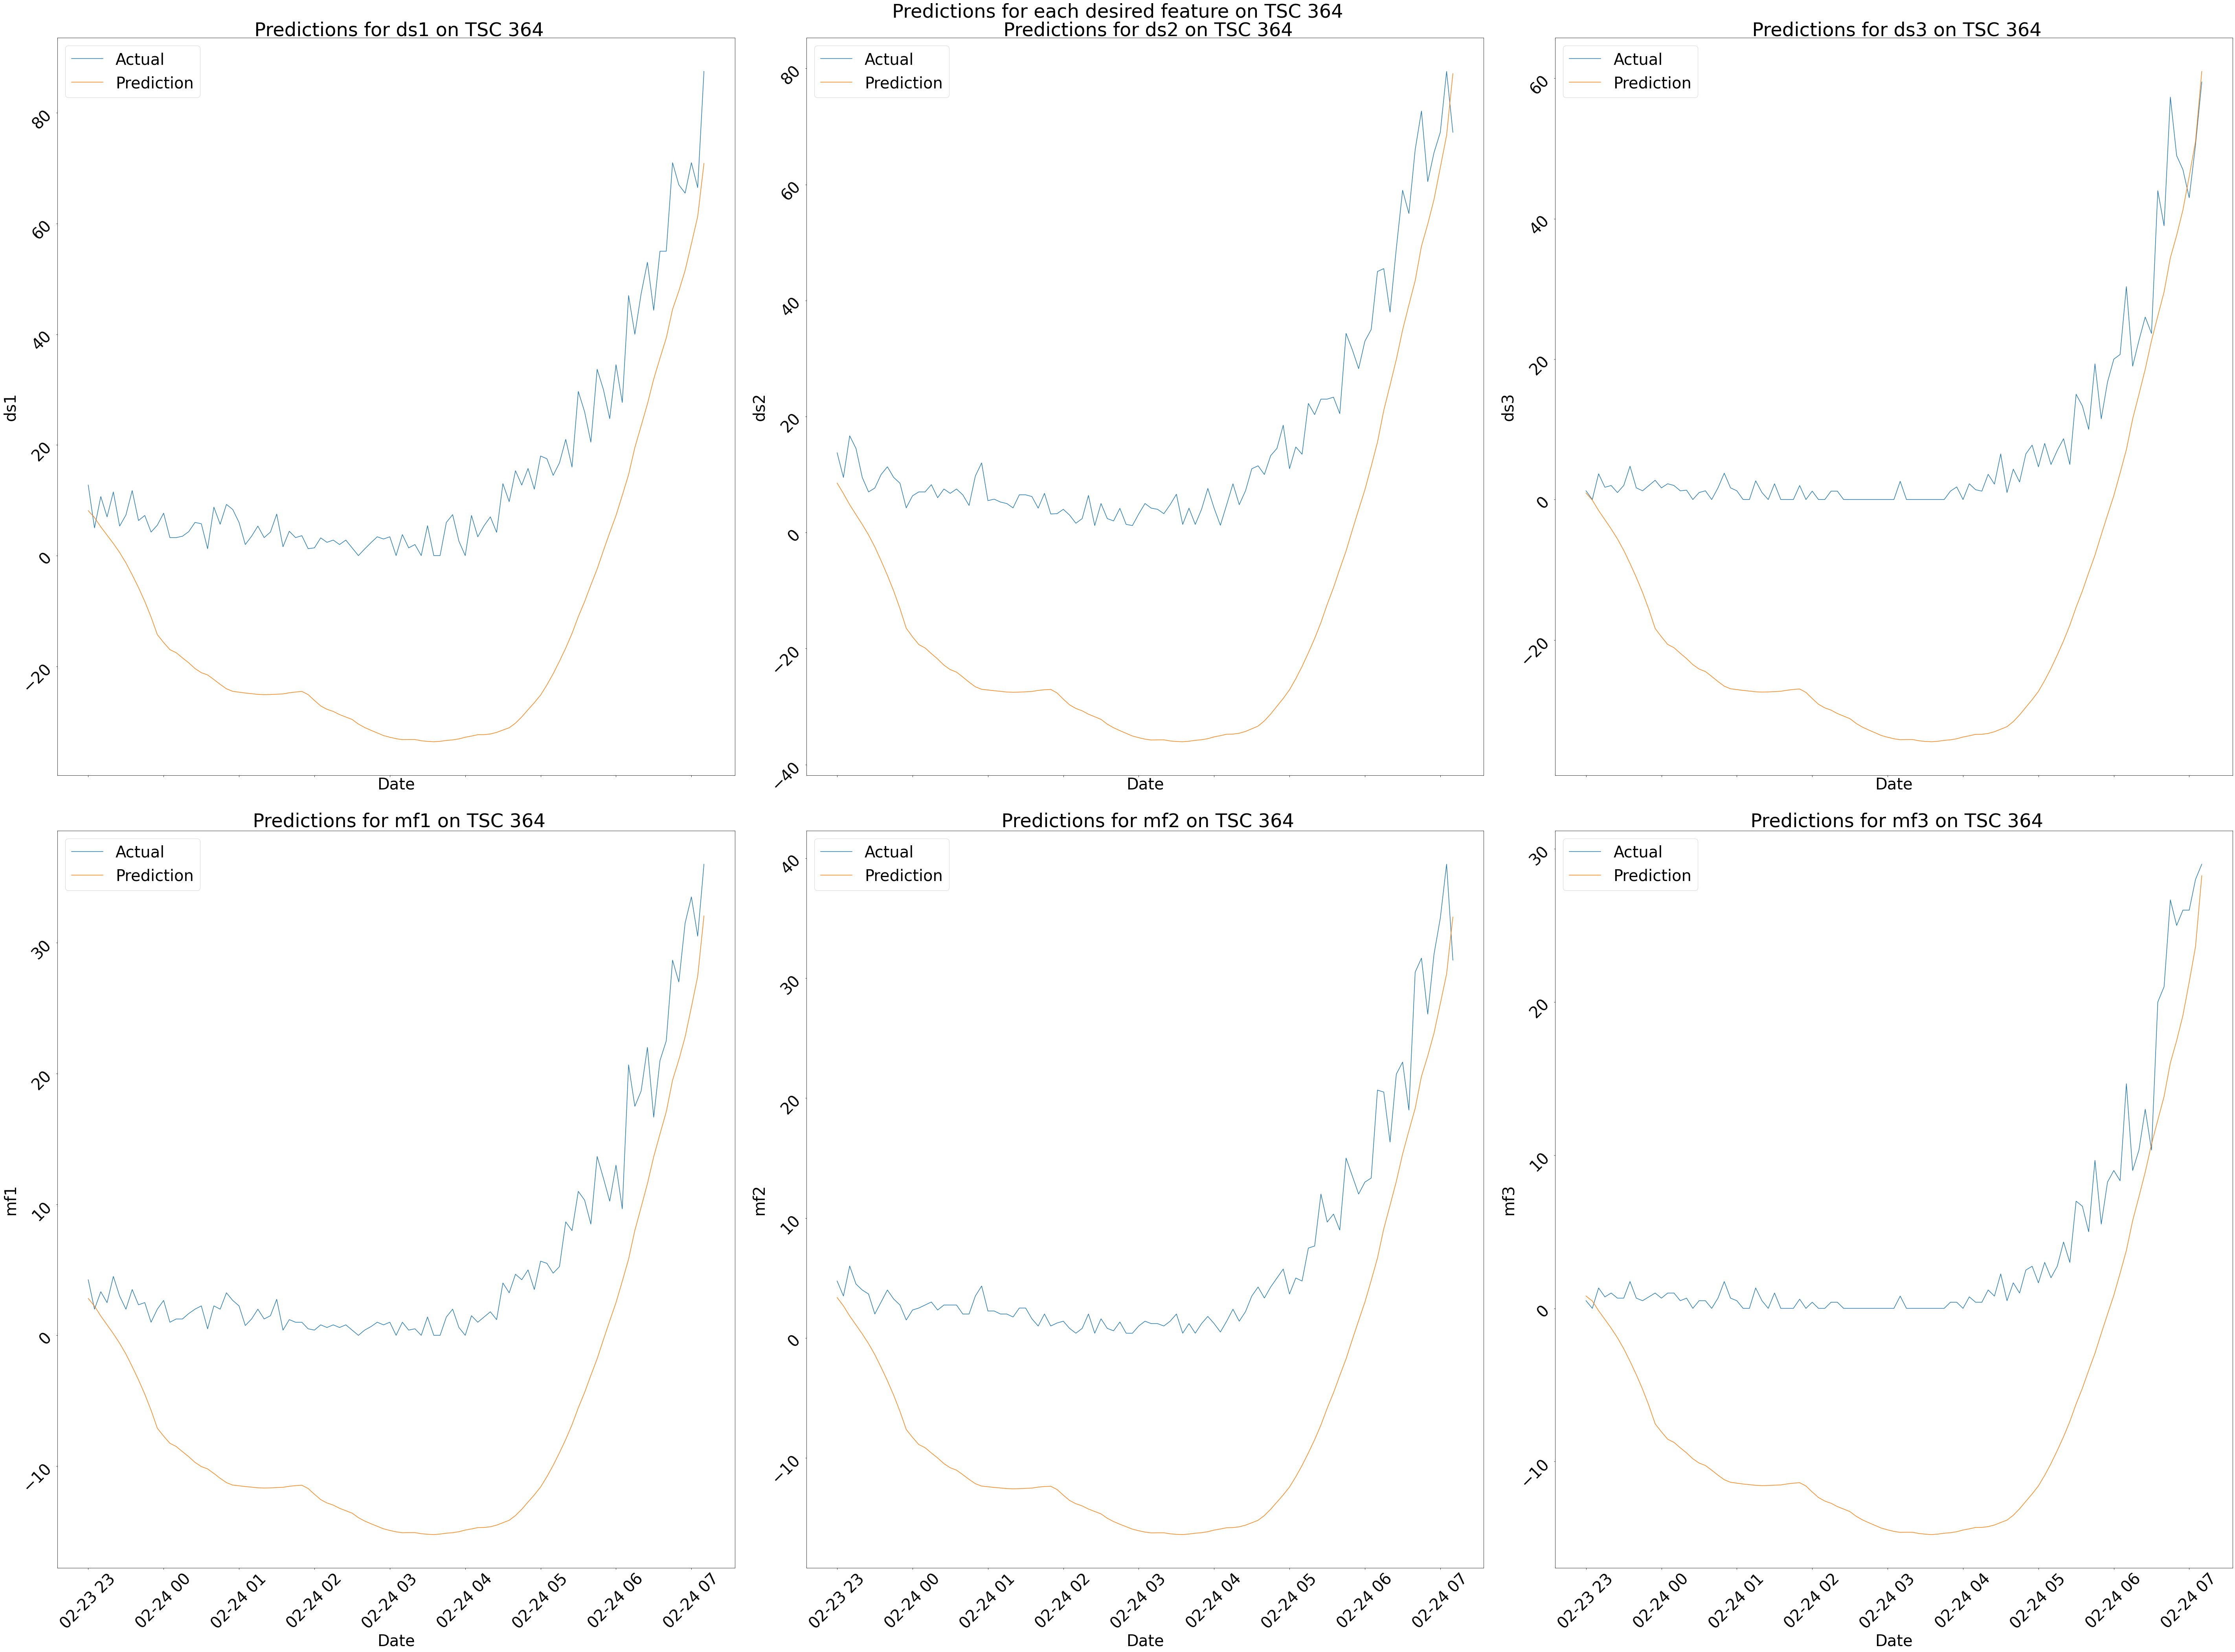

In [19]:
# Set font size when plotting
plt.rcParams.update({'font.size': 40})

# Features to plot predictions on
features = ["ds1", "ds2", "ds3", "mf1", "mf2", "mf3"]
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(80, 60))

# Plot predictions
for i in range(2):
    for j in range(3):
        if i < 1:
            feature = features[i + j]
        else:
            feature = features[i + j + 2]
            
        axes[i, j].plot(pred_df["recorded"], pred_df[feature], label="Actual")
        axes[i, j].plot(pred_df["recorded"], pred_df["pred_" + feature], label="Prediction")
        axes[i, j].set_xlabel("Date")
        axes[i, j].set_ylabel(f"{feature}")
        axes[i, j].set_title(f" Predictions for {feature} on TSC {tsc}")
        axes[i, j].legend()
        
        # Rotate x-axis labels for less clutter
        axes[i, j].tick_params(labelrotation=45)
        
# Title for whole subplot
fig.suptitle(f"Predictions for each desired feature on TSC {tsc}")

fig.tight_layout()
fig.savefig(f"tsc_{tsc}_pred.png", facecolor="w")

### Saving the trained model

In [20]:
torch.save(model.state_dict(), f"tsc_{tsc}_model.pt")

In [23]:
trained_model = LSTM().cuda()
trained_model.load_state_dict(torch.load(f"tsc_{tsc}_model.pt"))
trained_model.eval()

LSTM(
  (lstm): LSTM(6, 200, num_layers=2)
  (fc1): Linear(in_features=200, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=6, bias=True)
)